># 유통 판매량 예측 및 재고 최적화

# 단계 1 : 데이터 탐색 및 가설 도출

## 0. 미션
* 예측해야 할 핵심 상품 역할 분담
    * 44번 매장 3번 상품 : 윤영인, 이민희, 이예빈 에이블러
    * 44번 매장 12번 상품 : 심현보, 류호윤, 김아영 에이블러
    * 44번 매장 42번 상품 : 김가린, 문동규 에이블러
* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 & 시계열 패턴 발굴
    * 발굴한 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


## (1) 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

## (2) 데이터 불러오기

### 1) 데이터 로딩

In [2]:
path = './' # 루트 경로

# csv 데이터 호출
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

# 데이트타임 설정
sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

### 2) 기본 정보 조회

#### 일별 유가

In [3]:
# Date : 날짜
# WTI_Price : 유가(단위: 배럴당 달러)

display(oil_price.head(3))
display(oil_price.info())
display(oil_price.describe())

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       825 non-null    datetime64[ns]
 1   WTI_Price  795 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.0 KB


None

,Date,WTI_Price
count,825,795.000000
mean,2015-07-31 19:12:00.000000256,61.279082
min,2014-01-01 00:00:00,26.190000
25%,2014-10-16 00:00:00,44.950000
50%,2015-07-31 00:00:00,50.720000
75%,2016-05-16 00:00:00,82.805000
max,2017-02-28 00:00:00,107.950000
std,NaN,23.803058


In [4]:
# 결측행 존재
## 시계열 데이터 특성을 보존하면서 결측치 채우기
### 선형 보간 실행
oil_price['WTI_Price'].interpolate(method='linear', inplace=True)
### 첫번째 결측값을 전진 채우기로 처리
oil_price['WTI_Price'].fillna(method='bfill', inplace=True)

#### 일별 고객 매장 방문 수

In [5]:
# Date : 날짜
# Store_ID : 매장 UD
# CustomerCount : 고객 방문 수(= 구매 고객 수)
display(orders.head(3))
display(orders.info())
display(orders.describe())

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57558 entries, 0 to 57557
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           57558 non-null  datetime64[ns]
 1   Store_ID       57558 non-null  int64         
 2   CustomerCount  57558 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.3 MB


None

,Date,Store_ID,CustomerCount
count,57558,57558.000000,57558.000000
mean,2015-08-15 08:20:18.888773120,27.021509,1692.776921
min,2014-01-01 00:00:00,1.000000,5.000000
25%,2014-11-03 00:00:00,13.000000,1038.000000
50%,2015-08-25 00:00:00,27.000000,1390.000000
75%,2016-05-28 00:00:00,40.000000,2071.000000
max,2017-02-28 00:00:00,54.000000,8359.000000
std,NaN,15.598785,970.936760


#### 판매 정보

In [6]:
# Date : 날짜
# Store_ID : 매장 ID
# Qty : 판매 수량
# Product_ID : 상품 ID
display(sales.head(3))
display(sales.info())
display(sales.describe())

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934275 entries, 0 to 934274
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        934275 non-null  datetime64[ns]
 1   Store_ID    934275 non-null  int64         
 2   Qty         934275 non-null  float64       
 3   Product_ID  934275 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 28.5 MB


None

,Date,Store_ID,Qty,Product_ID
count,934275,934275.000000,934275.000000,934275.000000
mean,2015-07-31 14:51:55.703620352,27.520398,654.136862,17.164075
min,2014-01-01 00:00:00,1.000000,0.000000,3.000000
25%,2014-10-16 00:00:00,14.000000,10.000000,8.000000
50%,2015-08-01 00:00:00,28.000000,88.000000,15.000000
75%,2016-05-15 12:00:00,41.000000,562.000000,27.000000
max,2017-02-28 00:00:00,54.000000,124717.000000,42.000000
std,NaN,15.586942,1495.231047,10.370486


#### 상품 기본 정보

In [7]:
# Product_ID : 상품 ID
# Product_Code : 상품 Code
# SubCategory : 중분류
# Category : 대분류
# LeadTime : 발주 후 입고까지 소요 기간(Day)
# Price : 상품 판매 가격(달러)
display(products.head(3))
display(products.info())
display(products.describe())

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product_ID    16 non-null     int64 
 1   Product_Code  16 non-null     object
 2   SubCategory   16 non-null     object
 3   Category      16 non-null     object
 4   LeadTime      16 non-null     int64 
 5   Price         16 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 900.0+ bytes


None

,Product_ID,LeadTime,Price
count,16.000000,16.000000,16.000000
mean,18.687500,2.125000,26.437500
std,12.064929,0.341565,35.784482
min,3.000000,2.000000,4.000000
25%,9.500000,2.000000,6.000000
50%,15.500000,2.000000,16.000000
75%,27.500000,2.000000,30.250000
max,42.000000,3.000000,150.000000


#### 매장 기본 정보

In [8]:
# Store_ID : 매장 ID
# City : 매장이 위치한 도시
# State : 주
# Store_Type : 매장 크기 및 형태에 대한 분류
display(stores.head(3))
display(stores.info())
display(stores.describe())

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Store_ID    54 non-null     int64 
 1   City        54 non-null     object
 2   State       54 non-null     object
 3   Store_Type  54 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.8+ KB


None

,Store_ID,Store_Type
count,54.000000,54.000000
mean,27.500000,3.000000
std,15.732133,1.213136
min,1.000000,1.000000
25%,14.250000,2.000000
50%,27.500000,3.000000
75%,40.750000,4.000000
max,54.000000,5.000000


In [9]:
# \tMinnesota와 같이 \t 문자 제거
stores['State'] = stores['State'].str.replace('\t', '', regex=False)

## (3) 데이터 탐색

* 매장 정보 및 상품 정보 결합

In [10]:
# Orders
orders_exp_s = pd.merge(orders, stores, on='Store_ID', how='inner')

# Sales
sales_exp_s = pd.merge(sales, stores, on='Store_ID', how='inner')
sales_exp_p = pd.merge(sales_exp_s, products, on='Product_ID', how='inner')

In [13]:
orders_exp_s.head(5)

,Date,Store_ID,CustomerCount,City,State,Store_Type
0,2014-01-01,25,840,Olympia,Washington,4
1,2014-01-02,25,1315,Olympia,Washington,4
2,2014-01-03,25,1433,Olympia,Washington,4
3,2014-01-04,25,1613,Olympia,Washington,4
4,2014-01-05,25,878,Olympia,Washington,4


In [19]:
average_customer_count = orders_exp_s.groupby(['Store_Type', 'City'])['CustomerCount'].mean()

average_customer_count.head()

Store_Type  City        
1           Phoenix         2589.493892
            Raleigh         1715.076789
            Saint Paul      3593.222949
2           Atlanta         1424.189189
            Indianapolis    1401.136879
Name: CustomerCount, dtype: float64

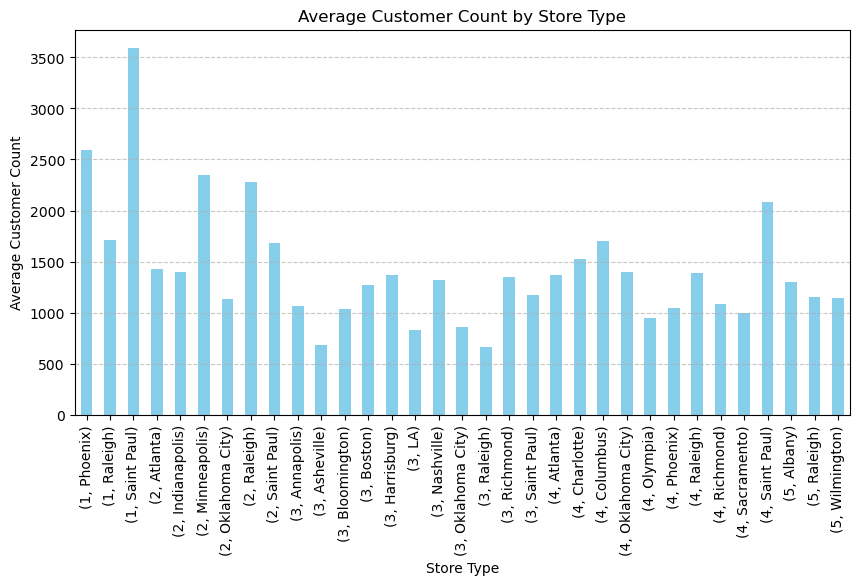

In [20]:
# 시각화
average_customer_count.plot(kind='bar', color='skyblue', figsize=(10, 5))
plt.title('Average Customer Count by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Customer Count')
plt.xticks(rotation=90)  # 막대의 레이블 회전 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 1) 시계열 패턴 탐색 1

* 대상 매장 : 44
* 대상 상품 : 3, 12, 42
* 대상 상품의 동일 카테고리의 상품별 판매량 추이
* 휘발류 가격과 상품 판매량 추이 비교
* 방문 고객수와 상품 판매량 추이 비교

#### 대상 매장(44), 대상 상품의 판매량 추이

In [11]:
# 44번 매장의 데이터만 추출
trg_orders = orders_exp_s[orders_exp_s['Store_ID'] == 44].reset_index(drop=True)
trg_sales = sales_exp_p[sales_exp_p['Store_ID'] == 44].reset_index(drop=True)

In [12]:
def pattern_draw_1(df):
    plt.figure(figsize=(15, 6))
    sns.scatterplot(x='Date', y='Qty', data=df)
    plt.title('Daily Sales Quantity per Product')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

##### 3번 상품의 판매량 추이

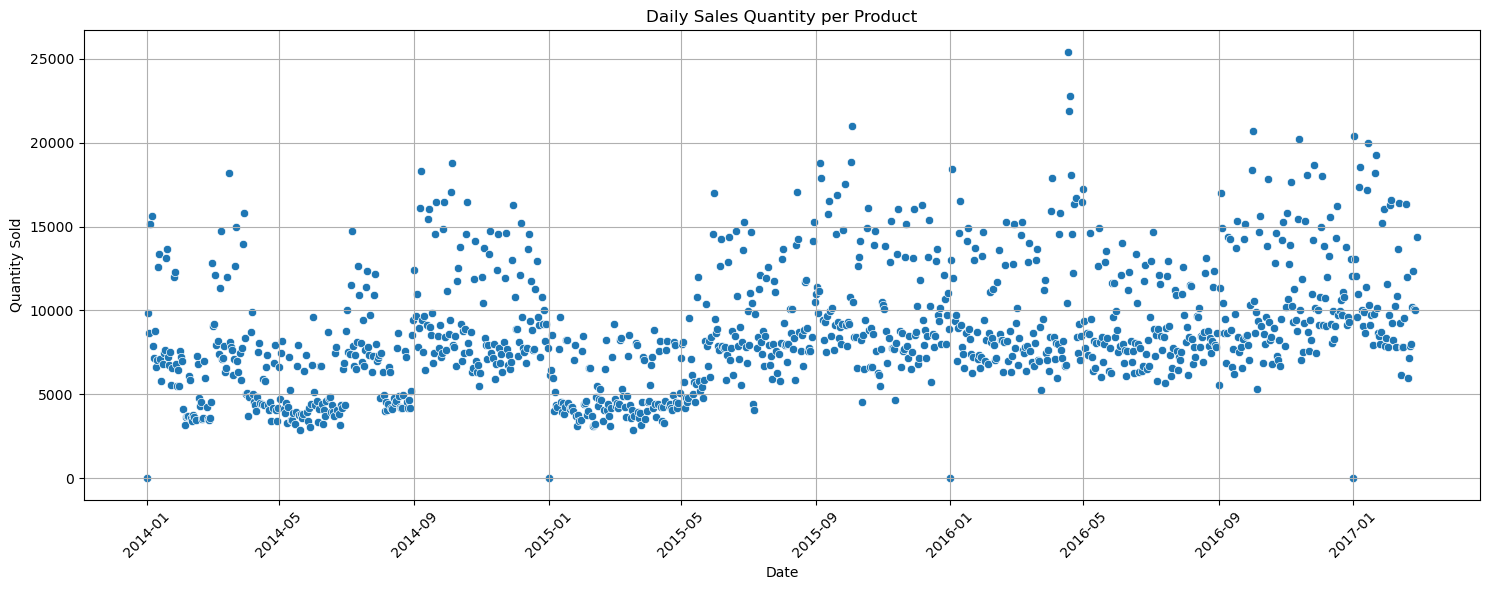

In [13]:
trg_sales_3 = trg_sales[trg_sales['Product_ID'] == 3]
pattern_draw_1(trg_sales_3)

##### 12번 상품의 판매량 추이

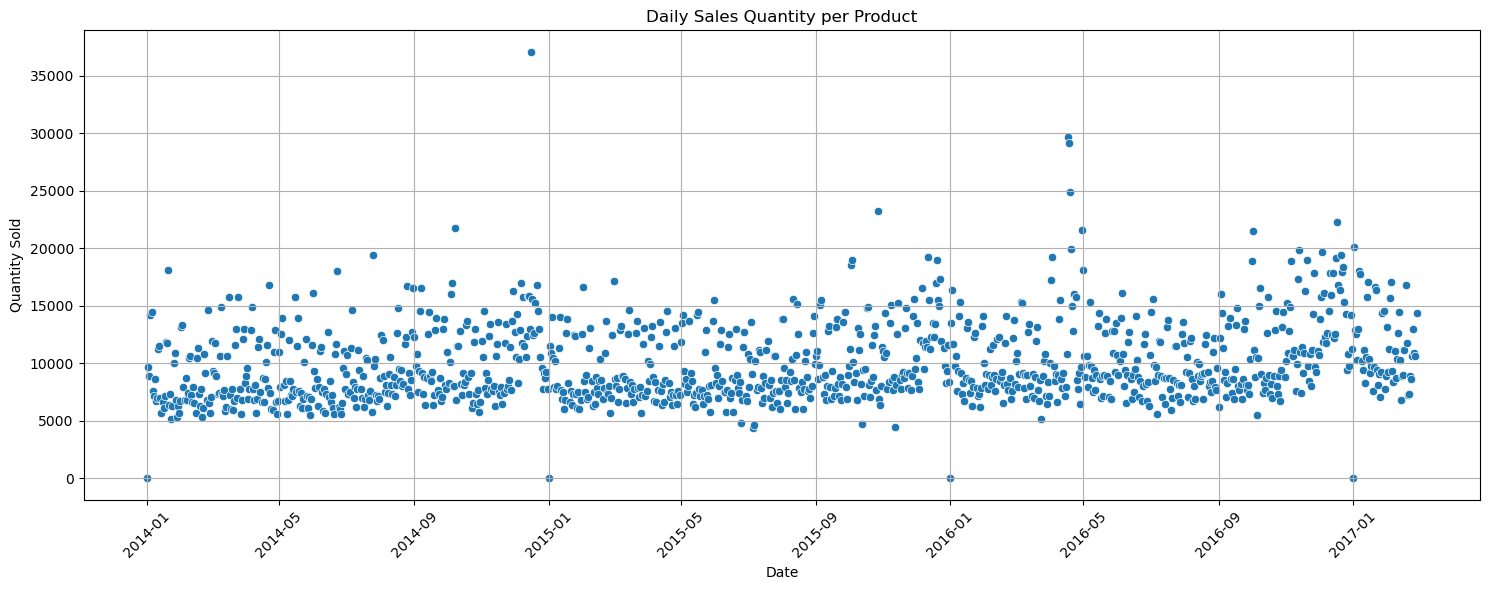

In [14]:
trg_sales_12 = trg_sales[trg_sales['Product_ID'] == 12]
pattern_draw_1(trg_sales_12)

##### 42번 상품의 판매량 추이

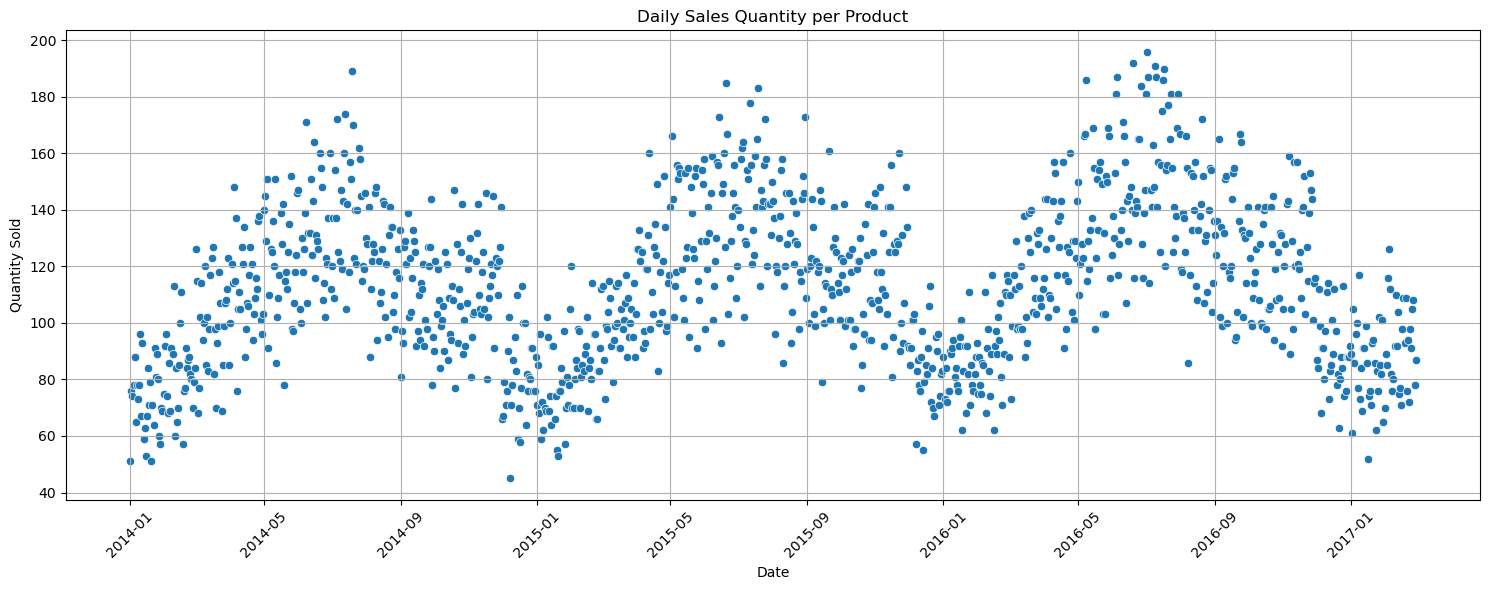

In [15]:
trg_sales_42 = trg_sales[trg_sales['Product_ID'] == 42]
pattern_draw_1(trg_sales_42)

#### 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [16]:
def pattern_draw_2(cat):
    cat_cnt = len(trg_sales[trg_sales['Category'] == cat]['Product_ID'].unique())
    df_list = []
    for i in range(cat_cnt):
        p_id = trg_sales[trg_sales['Category'] ==cat]['Product_ID'].unique()[i]
        df = trg_sales[trg_sales['Product_ID'] == p_id]
        df_list.append(df)
    
    # 서브플롯 생성
    fig, axes = plt.subplots(cat_cnt, 1, figsize=(15, 12))
    for i in range(cat_cnt):
        p_id = trg_sales[trg_sales['Category'] == cat]['Product_ID'].unique()[i]
        sns.scatterplot(ax=axes[i], x='Date', y='Qty', data=df_list[i])
        axes[i].set_title(f'Daily Sales Quantity for Product {p_id}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Quantity Sold')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True)

##### 3번 상품과 동일한 카테고리 상품 판매량 추이 확인

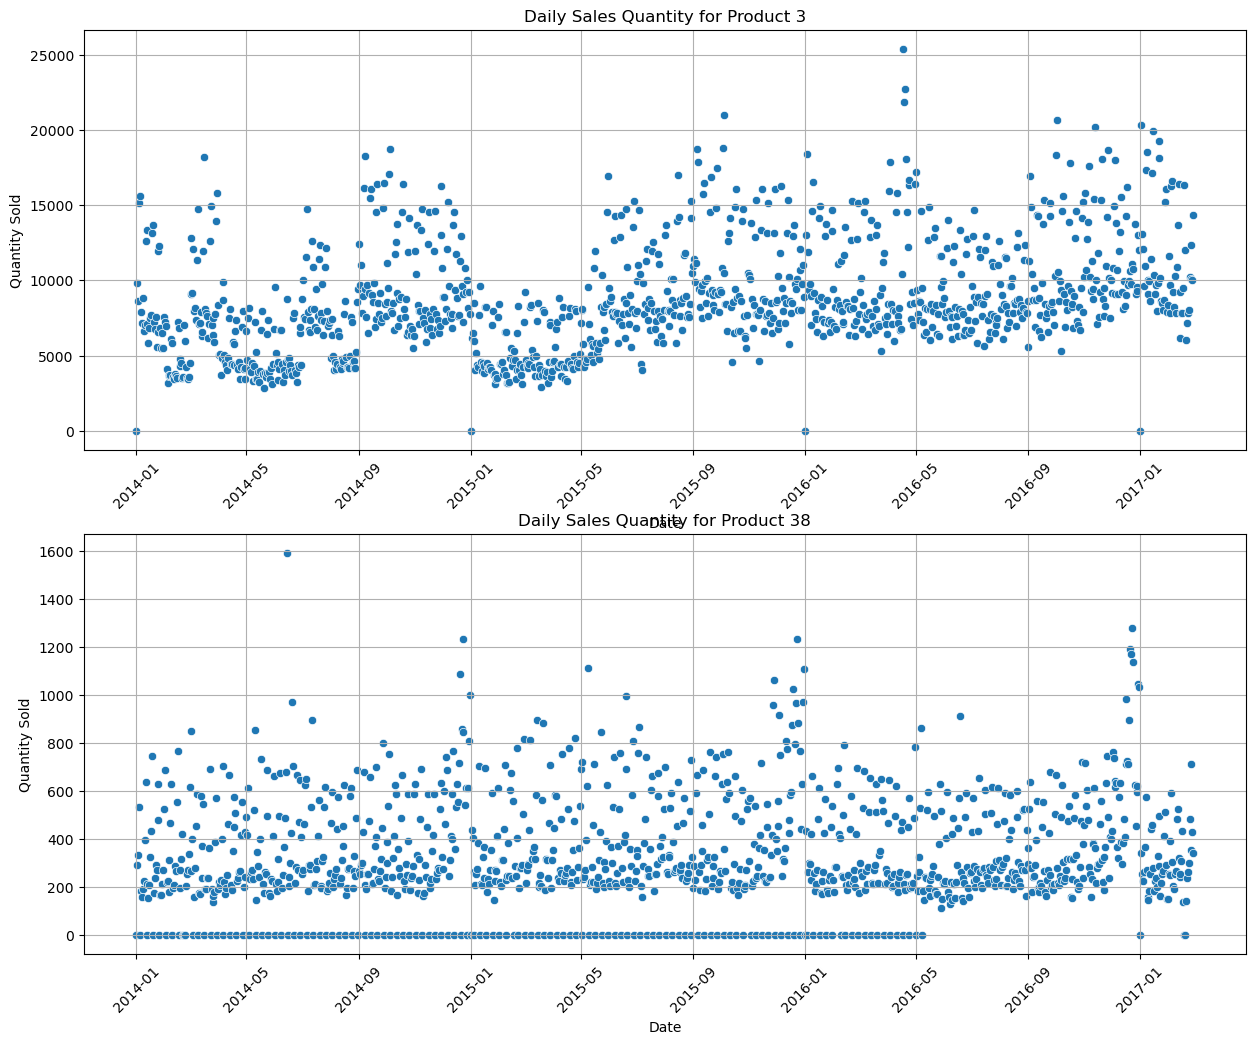

In [17]:
cat = trg_sales_3['Category'][0]
pattern_draw_2(cat)

##### 12번 상품과 동일한 카테고리 상품 판매량 추이 확인

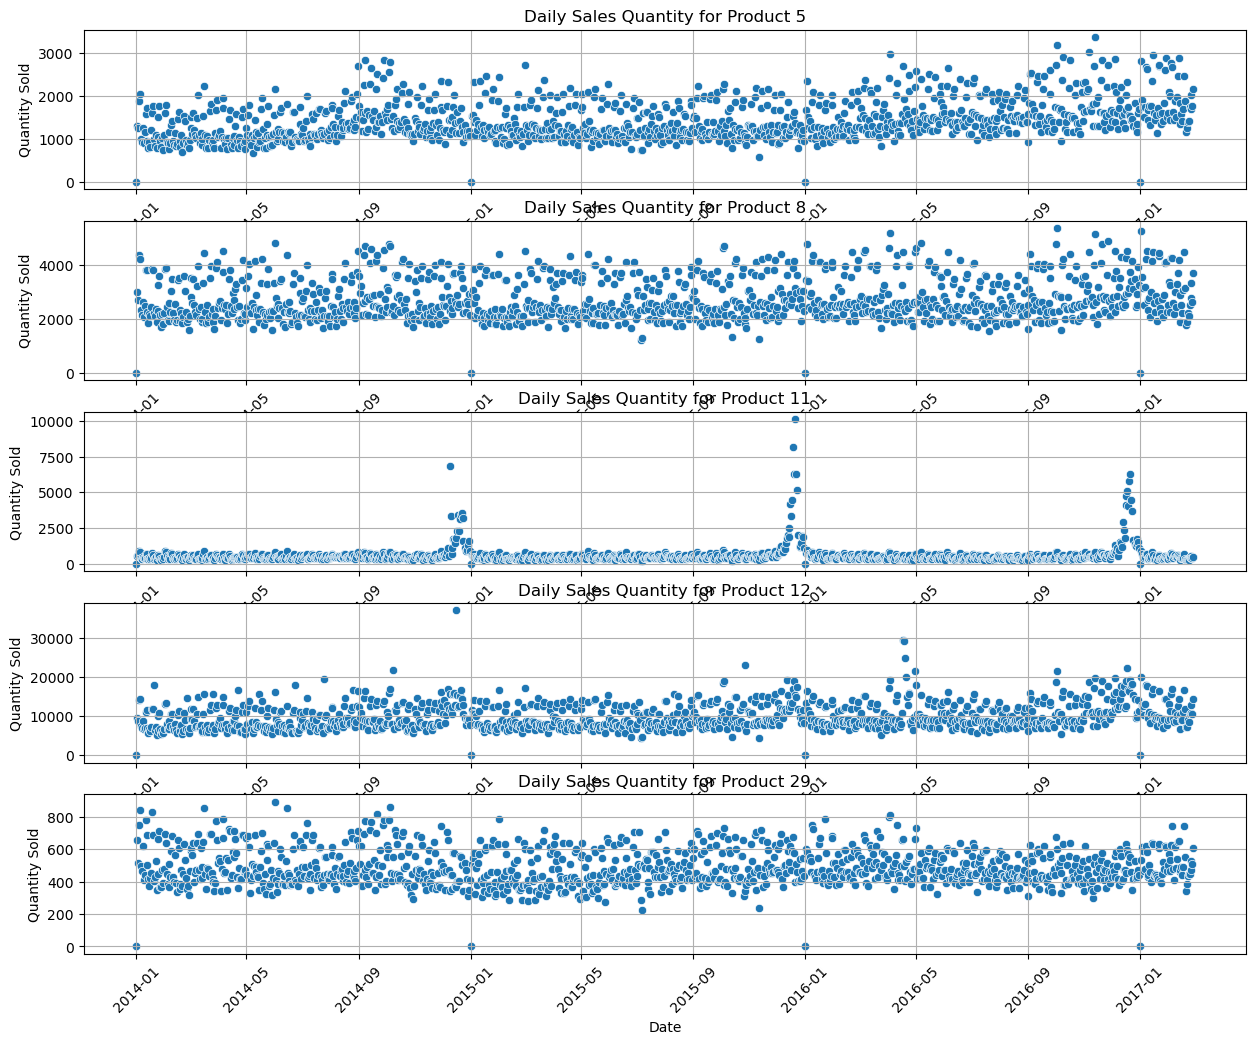

In [18]:
cat = trg_sales_12['Category'].values[0]
pattern_draw_2(cat)

##### 42번 상품과 동일한 카테고리 상품 판매량 추이 확인

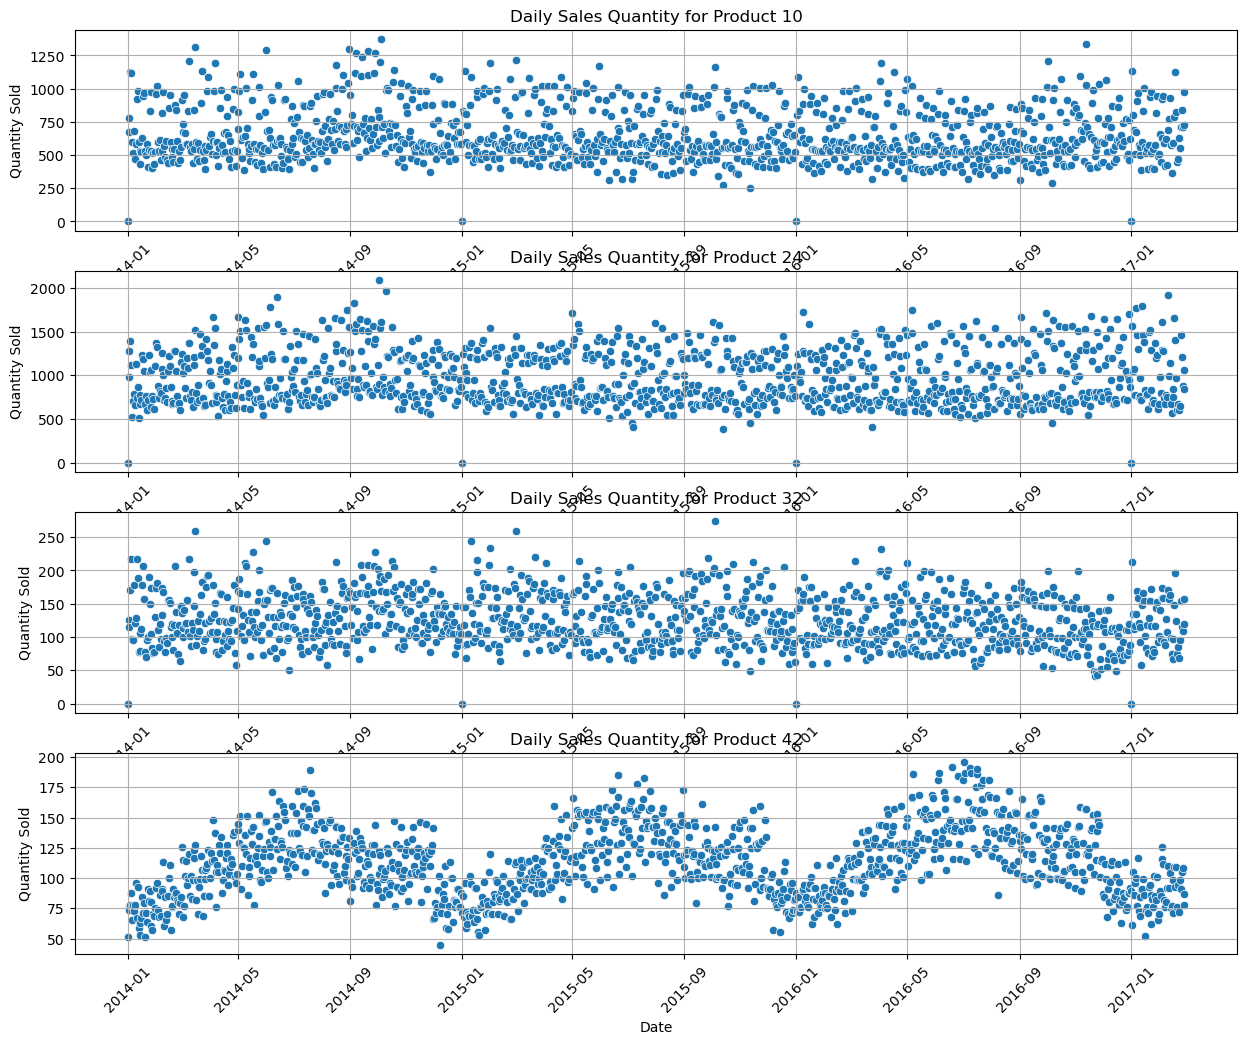

In [19]:
cat = trg_sales_42['Category'].values[0]
pattern_draw_2(cat)

#### 휘발류 가격과 상품 판매량 추이 비교

In [20]:
def pattern_draw_3(df):
    # 날짜 데이터 타입 확인 및 변환
    oil_price['Date'] = pd.to_datetime(oil_price['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    
    # 이동 평균 계산 (7일 기준)
    df['Moving_Avg'] = df['Qty'].rolling(window=30, center=True).mean()

    # 데이터 시각화
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax2 = ax1.twinx()
    ax1.plot(oil_price['Date'], oil_price['WTI_Price'], 'g-', label='WTI Oil Price')
    ax2.plot(df['Date'], df['Qty'], 'b-', alpha=0.3, label='Original Sales Quantity')  # 원본 데이터는 투명하게 표시
    ax2.plot(df['Date'], df['Moving_Avg'], 'b-', label='Smoothed Sales Quantity')  # 평활화된 데이터

    ax1.set_xlabel('Date')
    ax1.set_ylabel('WTI Oil Price', color='g')
    ax2.set_ylabel('Sales Quantity', color='b')

    plt.title('Comparison of WTI Oil Prices and Sales Quantity Over Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

##### 3번 상품의 판매량 추이

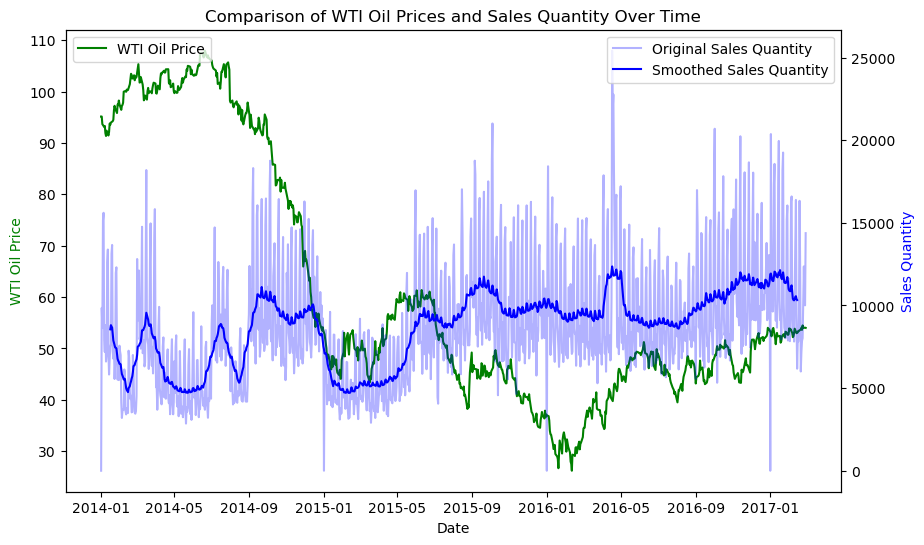

In [21]:
pattern_draw_3(trg_sales_3)

##### 12번 상품의 판매량 추이

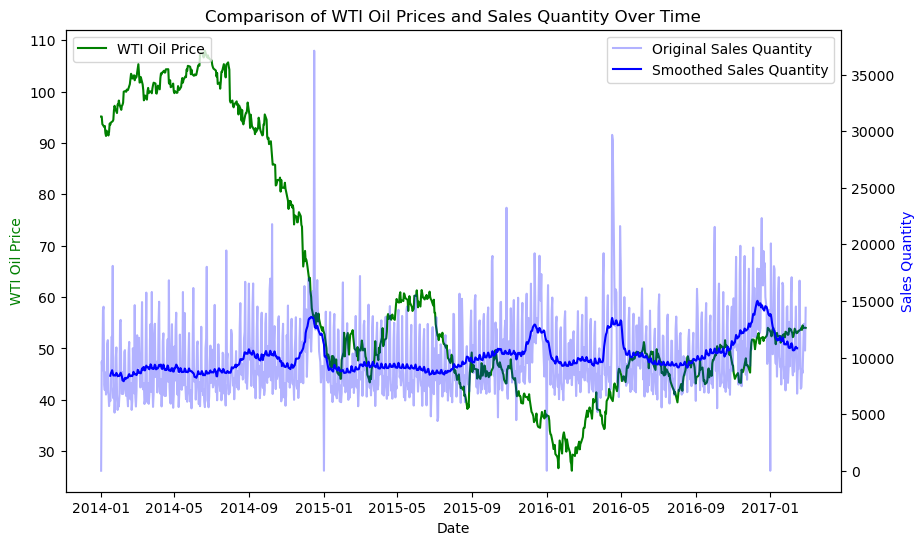

In [22]:
pattern_draw_3(trg_sales_12)

##### 42번 상품의 판매량 추이

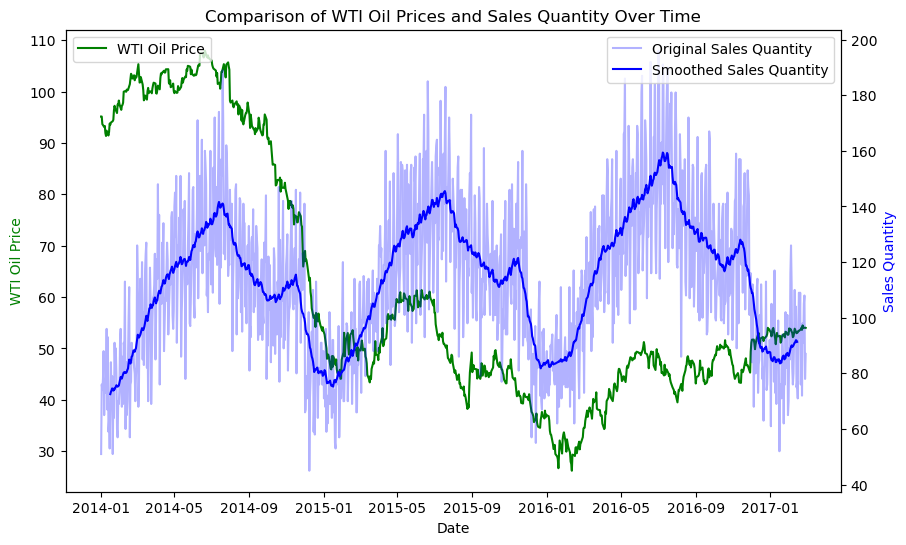

In [23]:
pattern_draw_3(trg_sales_42)

# 유가가 상승 추세일 때, 42번 상품(농산물)도 상승 추세를 보이고, 유가가 하락 추세일 때, 42번 상품도 하락 추세를 보인다.
# 따라서, 유가의 변동과 42번 상품의 판매량이 서로 상관이 있다고 가정할 수 있다.

#### 방문 고객수와 상품 판매량 추이 비교

In [24]:
def pattern_draw_4(df):
    # 날짜 데이터 타입 확인 및 변환
    trg_orders['Date'] = pd.to_datetime(trg_orders['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    
    # 이동 평균 계산 (7일 기준)
    trg_orders['Moving_Avg_Customer'] = trg_orders['CustomerCount'].rolling(window=7, center=True).mean()
    df['Moving_Avg_Qty'] = df['Qty'].rolling(window=7, center=True).mean()

    # 데이터 시각화
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax2 = ax1.twinx()
    ax1.plot(trg_orders['Date'], trg_orders['CustomerCount'], 'g-', alpha=0.3, label='Original Customer Count')  # 원본 데이터는 투명하게 표시
    ax1.plot(trg_orders['Date'], trg_orders['Moving_Avg_Customer'], 'g-', label='Smoothed Customer Count')  # 평활화된 데이터
    ax2.plot(df['Date'], df['Qty'], 'b-', alpha=0.3, label='Original Sales Quantity')  # 원본 데이터는 투명하게 표시
    ax2.plot(df['Date'], df['Moving_Avg_Qty'], 'b-', label='Smoothed Sales Quantity')  # 평활화된 데이터

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Customer Count', color='g')
    ax2.set_ylabel('Sales Quantity', color='b')

    plt.title('Comparison of Customer Visits and Sales Quantity')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

##### 3번 상품의 판매량 추이

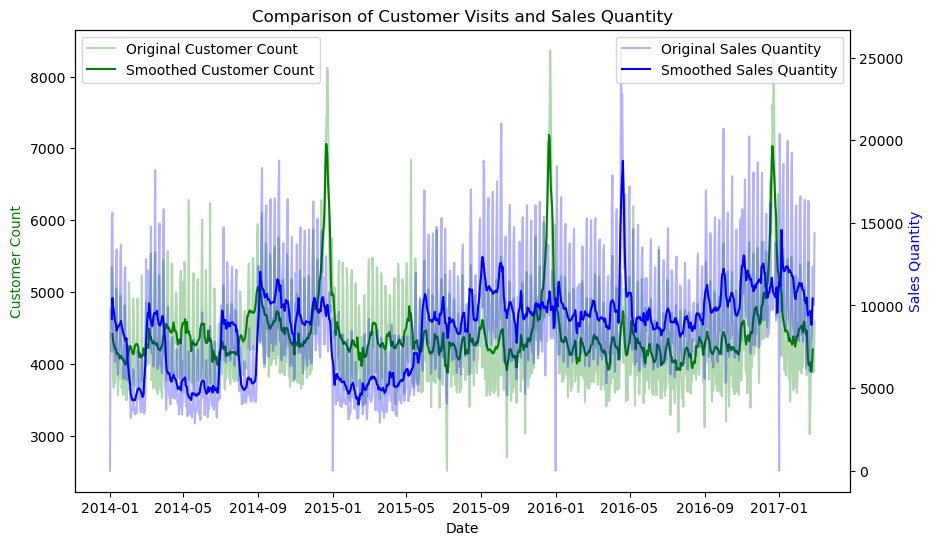

In [25]:
pattern_draw_4(trg_sales_3)

##### 12번 상품의 판매량 추이

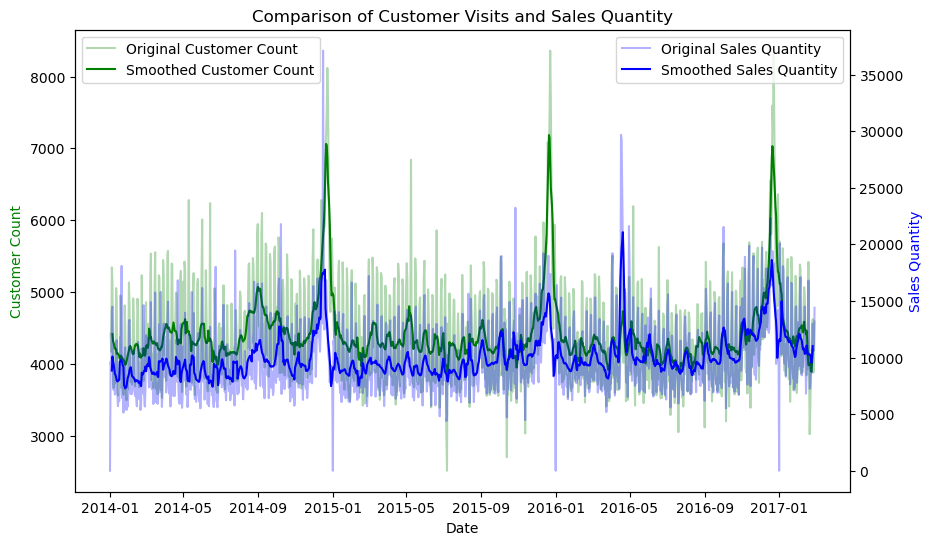

In [26]:
pattern_draw_4(trg_sales_12)

##### 42번 상품의 판매량 추이

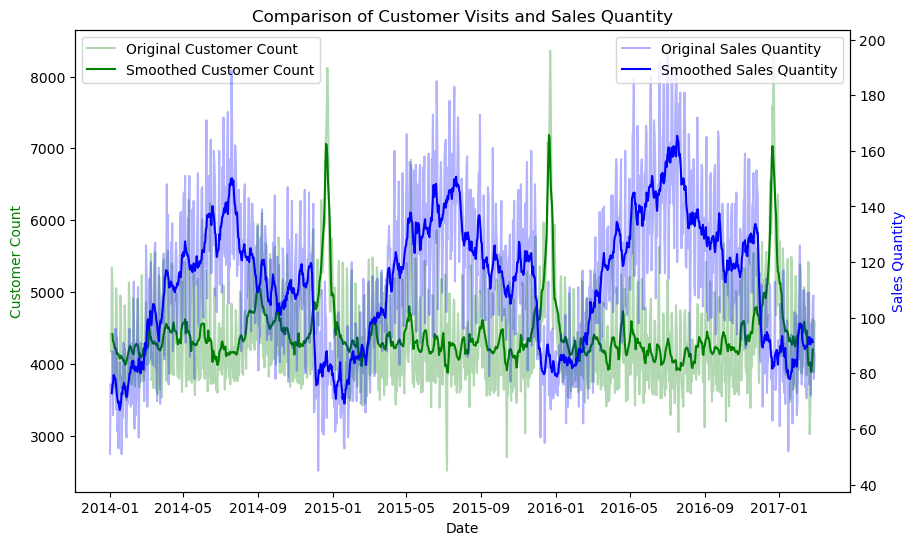

In [27]:
pattern_draw_4(trg_sales_42)

### 2) 시계열 패턴 탐색 2

#### 대상 매장(44), 대상 상품의 판매량 추이 -> 위와 동일

##### 3번 상품의 판매량 추이

##### 12번 상품의 판매량 추이

##### 42번 상품의 판매량 추이

#### 요일별 변화량 비교

In [28]:
def month_week_visual(df_org):
    df = df_org.copy()
    df['Date'] = pd.to_datetime(df['Date'])  # 날짜를 datetime 타입으로 확실히 변환
    df['Weekday'] = df['Date'].dt.day_name()
    df['Month'] = df['Date'].dt.month_name()

    # 요일별로 그룹화하여 평균 판매량 계산
    weekday_sales = df.groupby('Weekday')['Qty'].mean()
    # 월별로 그룹화하여 평균 판매량 계산
    monthly_sales = df.groupby('Month')['Qty'].mean()

    # 요일 순서 정의
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    # 월 순서 정의
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

    # 요일별 평균 판매량 그래프
    weekday_sales = weekday_sales.reindex(weekday_order)  # 요일 순서에 맞게 재정렬
    # 월별 평균 판매량 그래프
    monthly_sales = monthly_sales.reindex(month_order)  # 월 순서에 맞게 재정렬

    # 시각화
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 subplot
    weekday_sales.plot(kind='bar', color='skyblue')
    plt.title('Average Sales per Weekday')
    plt.xlabel('Weekday')
    plt.ylabel('Average Quantity Sold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 subplot
    monthly_sales.plot(kind='bar', color='lightgreen')
    plt.title('Average Sales per Month')
    plt.xlabel('Month')
    plt.ylabel('Average Quantity Sold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

##### 3번 상품의 판매량 추이

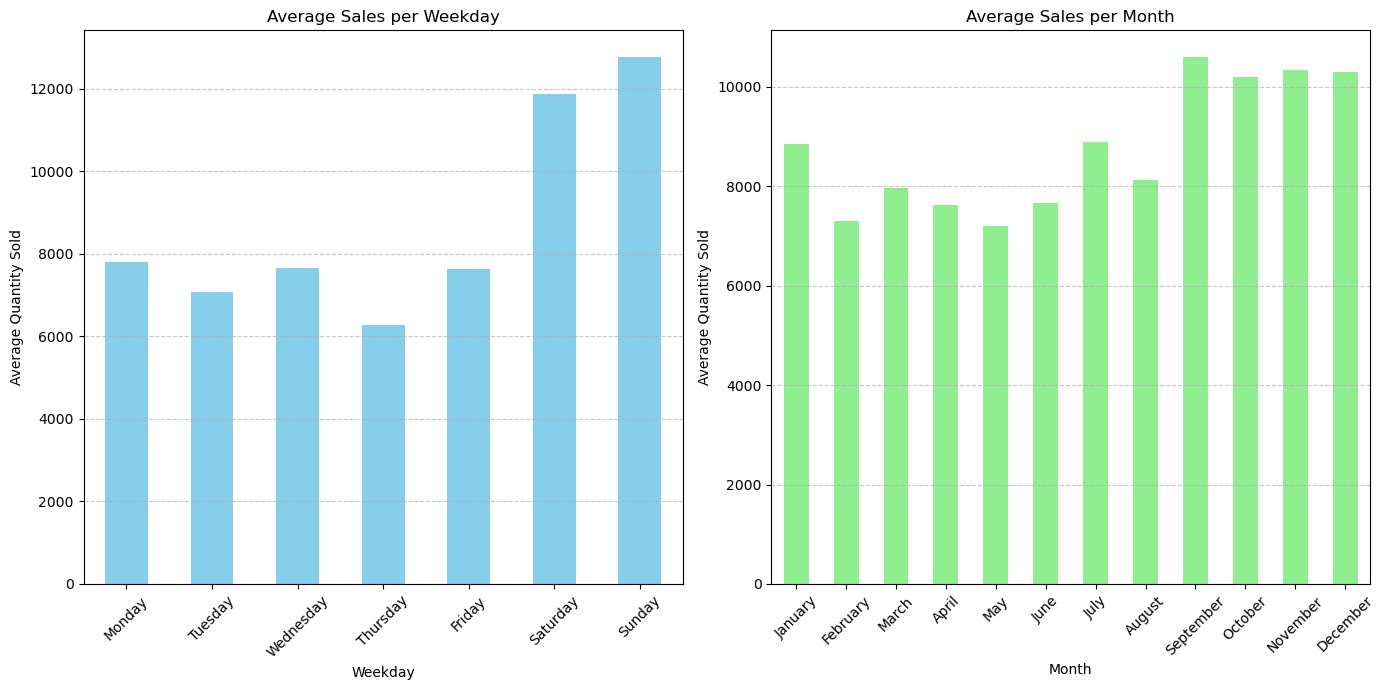

In [29]:
month_week_visual(trg_sales_3)

##### 12번 상품의 판매량 추이

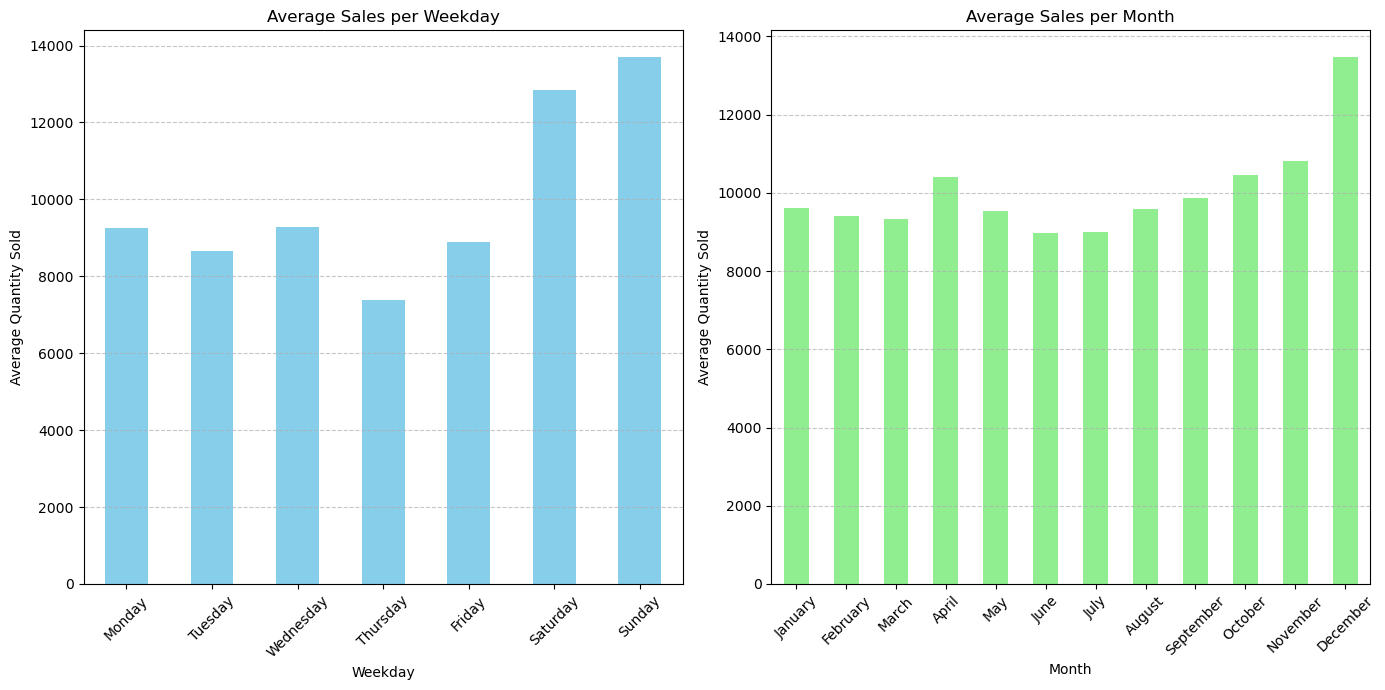

In [30]:
month_week_visual(trg_sales_12)

##### 42번 상품의 판매량 추이

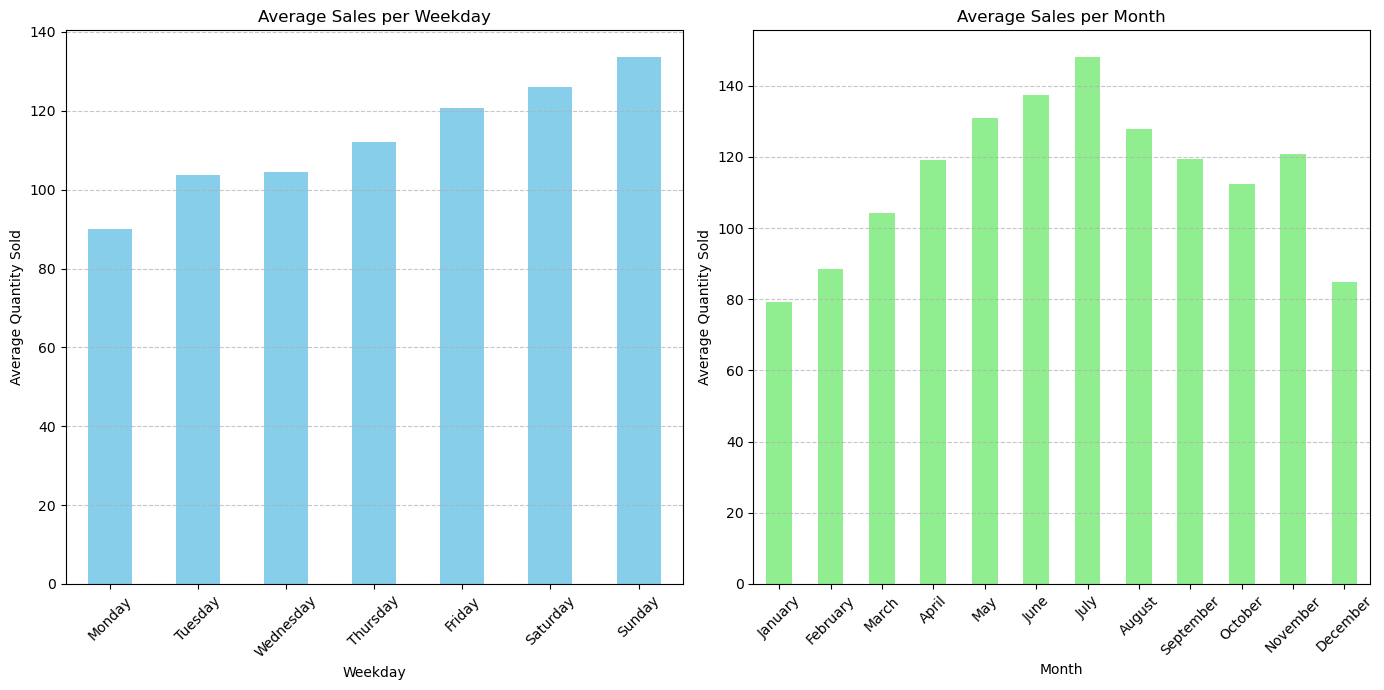

In [31]:
month_week_visual(trg_sales_42)

### 3) 시계열 데이터 분해

In [45]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(20, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

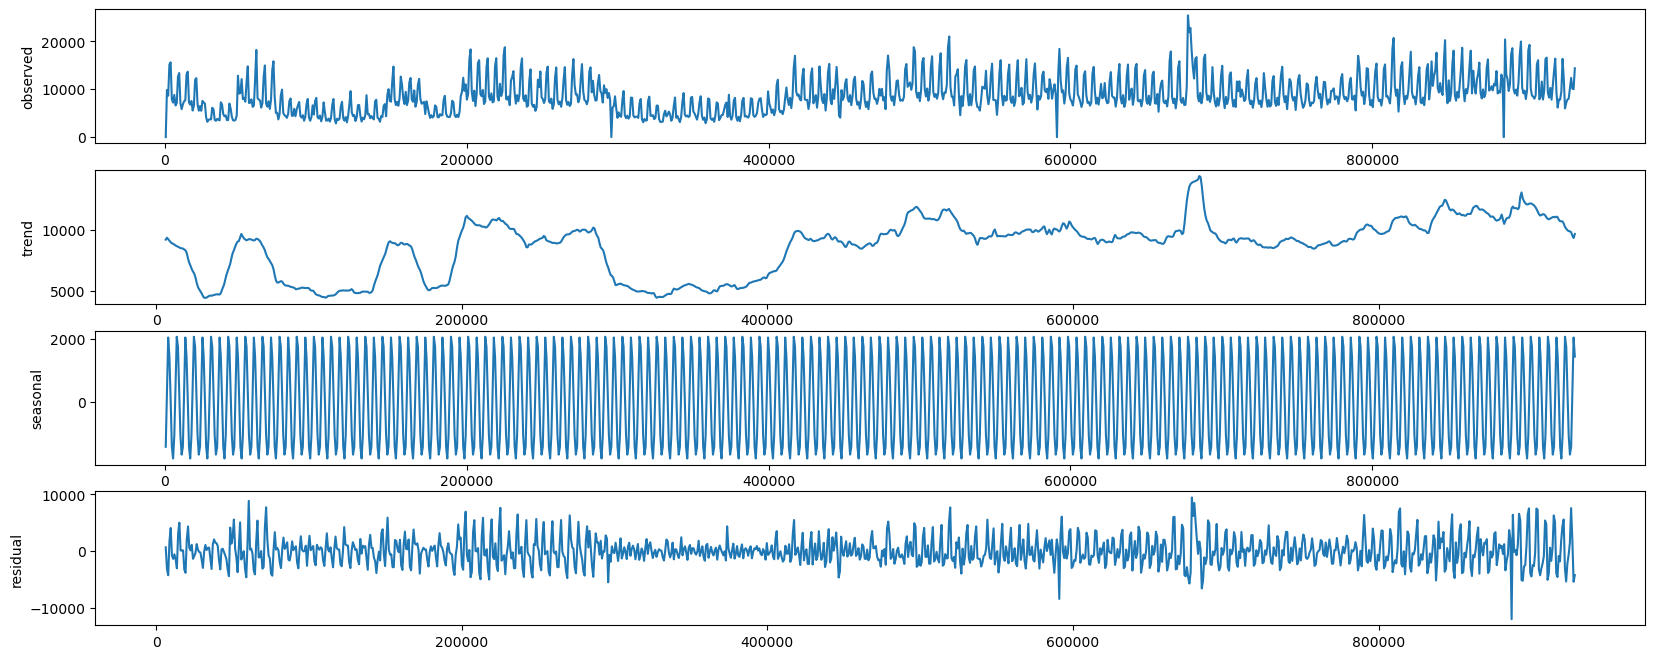

,observed,trend,seasonal,residual
645,0.0,NaN,-1415.869568,NaN
1456,9853.0,NaN,263.927610,NaN
2267,8647.0,NaN,2049.630432,NaN
3078,15153.0,NaN,1445.470379,NaN
3889,15606.0,NaN,83.285634,NaN
...,...,...,...,...
930865,10208.0,NaN,-1664.309163,NaN
931676,12361.0,NaN,-1415.869568,NaN
932487,10108.0,NaN,263.927610,NaN
933298,10006.0,NaN,2049.630432,NaN


In [46]:
decomp_plot(3, '2014-01-01', '2017-02-28', 14)

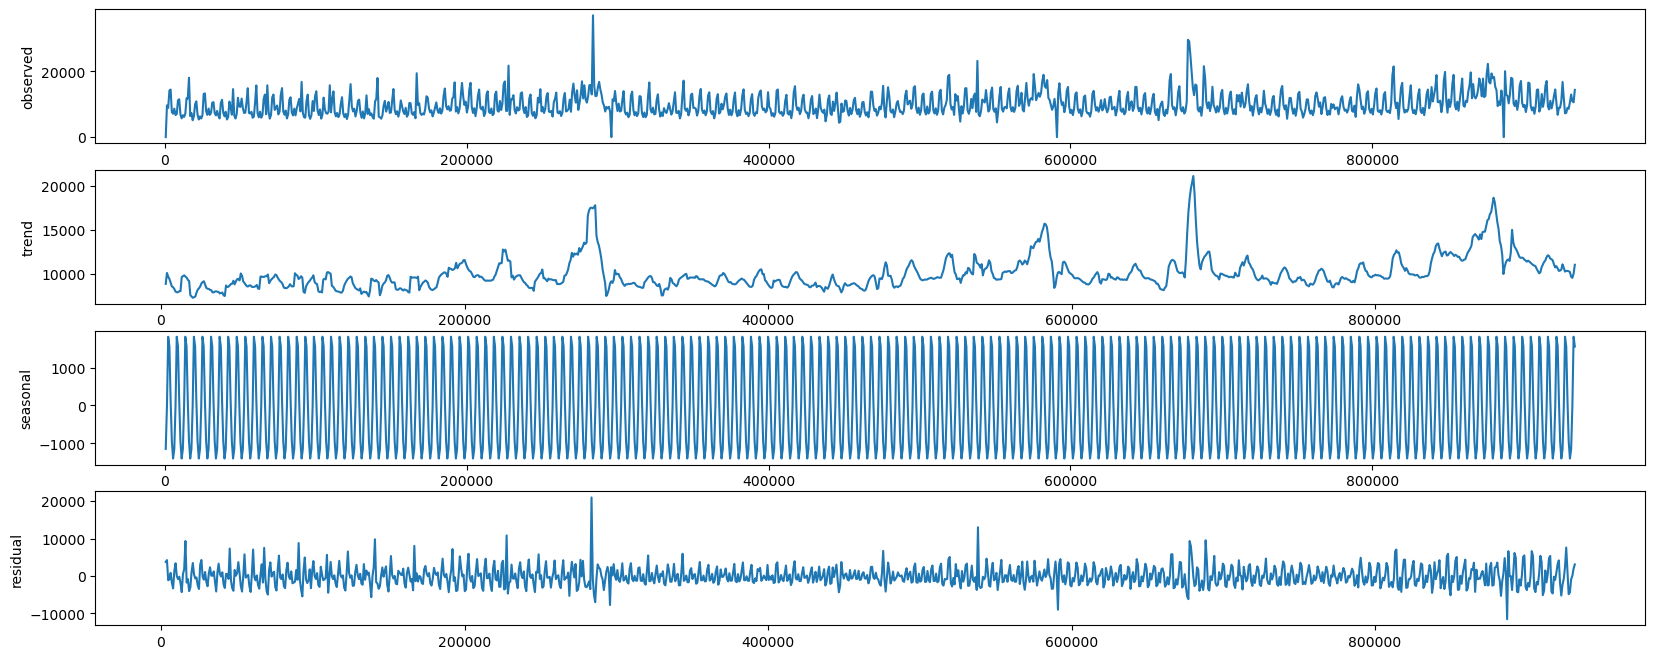

,observed,trend,seasonal,residual
651,0.0,NaN,-1146.541155,NaN
1462,9647.0,NaN,-13.491675,NaN
2273,8879.0,NaN,1813.618754,NaN
3084,14188.0,8848.857143,1556.983945,3782.158912
3895,14490.0,10089.285714,137.196726,4263.517560
...,...,...,...,...
930871,10630.0,10010.428571,-1399.585480,2019.156908
931682,12978.0,11014.142857,-1146.541155,3110.398298
932493,10899.0,NaN,-13.491675,NaN
933304,10618.0,NaN,1813.618754,NaN


In [48]:
decomp_plot(12, '2014-01-01', '2017-02-28', 7)

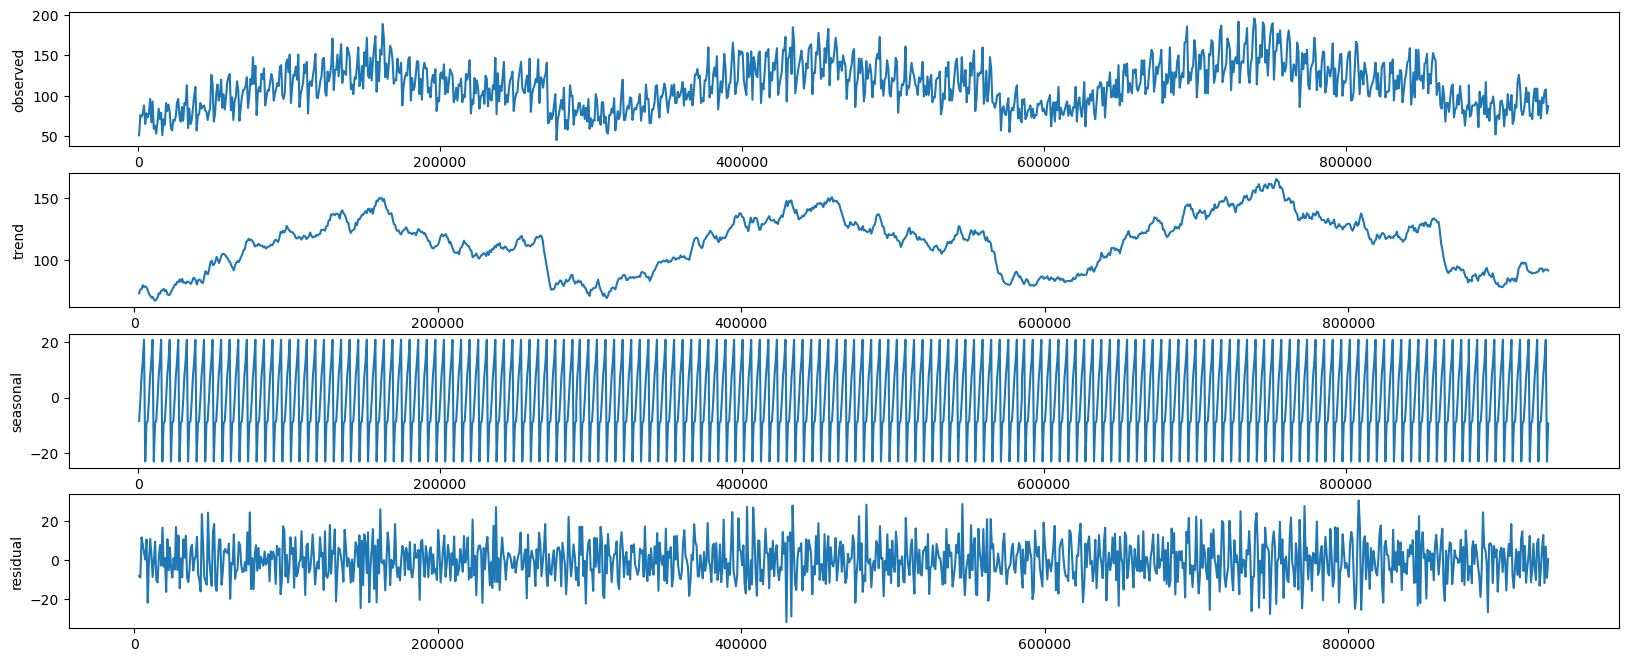

,observed,trend,seasonal,residual
658,51.0,NaN,-8.419806,NaN
1469,76.0,NaN,-0.937227,NaN
2280,74.0,NaN,7.709985,NaN
3091,78.0,72.857143,13.207858,-8.065001
3902,88.0,76.000000,20.790125,-8.790125
...,...,...,...,...
930878,91.0,92.285714,7.709985,-8.995700
931689,105.0,91.285714,13.207858,0.506428
932500,108.0,NaN,20.790125,NaN
933311,78.0,NaN,-23.015624,NaN


In [49]:
decomp_plot(42, '2014-01-01', '2017-02-28', 7)

### 4) 그 외 패턴 도출

#### 요일, 월별 방문 고객 수 비교

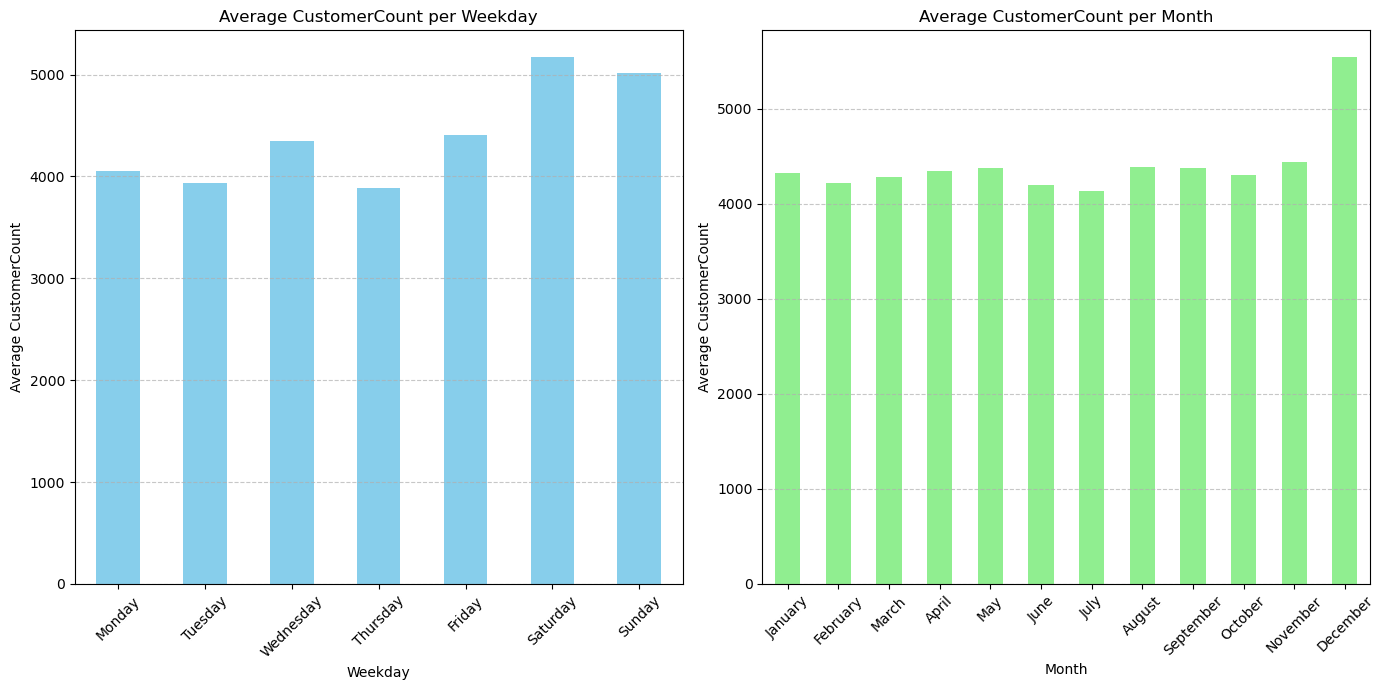

In [36]:
def month_week_visual_2(df_org):
    df = df_org.copy()
    df['Date'] = pd.to_datetime(df['Date'])  # 날짜를 datetime 타입으로 확실히 변환
    df['Weekday'] = df['Date'].dt.day_name()
    df['Month'] = df['Date'].dt.month_name()

    # 요일별로 그룹화하여 평균 판매량 계산
    weekday_sales = df.groupby('Weekday')['CustomerCount'].mean()
    # 월별로 그룹화하여 평균 판매량 계산
    monthly_sales = df.groupby('Month')['CustomerCount'].mean()

    # 요일 순서 정의
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    # 월 순서 정의
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

    # 요일별 평균 판매량 그래프
    weekday_sales = weekday_sales.reindex(weekday_order)  # 요일 순서에 맞게 재정렬
    # 월별 평균 판매량 그래프
    monthly_sales = monthly_sales.reindex(month_order)  # 월 순서에 맞게 재정렬

    # 시각화
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 subplot
    weekday_sales.plot(kind='bar', color='skyblue')
    plt.title('Average CustomerCount per Weekday')
    plt.xlabel('Weekday')
    plt.ylabel('Average CustomerCount')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 subplot
    monthly_sales.plot(kind='bar', color='lightgreen')
    plt.title('Average CustomerCount per Month')
    plt.xlabel('Month')
    plt.ylabel('Average CustomerCount')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

month_week_visual_2(trg_orders)

## (4) 패턴 정리

* 가설 1: 원유 가격 상승과 대량 구매 패턴
    * 배경
        * 마트 방문 시 일반적으로 거리가 멀어 자동차에 의존하는 미국인들은, 원유 가격의 상승이 차량 유지 비용의 증가를 가져온다. 이는 소비자가 불필요한 외출을 줄이고, 필요한 경우에만 외출을 계획하게 만드는 원인이 된다.

    * 관찰 결과
        * 원유 가격이 상승함에 따라 소비자들은 필수적이고 장기 보관이 가능한 생활 필수품을 대량으로 구매하는 경향을 보인다.
        * 특히, 식료품 분야에서 이러한 경향이 두드러지게 나타나며, 'Drink'와 'Food' 카테고리는 원유 가격 변동의 영향을 덜 받는 반면, 'Grocery' 카테고리는 원유 가격 추세와 유사한 판매량 변동 추세를 보여 이에 민감한 것으로 분석된다.

    * 결론
        * **이는 소비자들이 경제적 부담을 고려하여 필수적이지 않은 소비를 줄이고, 필수적인 품목에 대해 대량 구매를 선호함을 시사한다. 이러한 행동은 소매업자들에게 재고 관리와 마케팅 전략에 중요한 데이터를 제공한다.**

* 가설 2: 유제품의 필수성과 소비 패턴
    * 배경
        * 유제품은 미국인의 식생활에서 중요한 구성 요소이다.
        * 대다수의 소비자는 마트 방문 시 유제품을 필수적으로 구매하는 것으로 나타났다.

    * 관찰 결과
        * 고객 수와 유제품의 판매량 변화를 분석한 결과, 두 데이터 간에는 거의 일치하는 추세가 나타나 이는 유제품이 미국인의 주요 식품으로서 필수적인 역할을 한다는 사실을 확인시켜 준다.
        * 고객 수 증가는 직접적으로 유제품 판매량 증가로 이어진다.

    * 결론
        * 이러한 결과는 유제품이 소비자에게 필수적인 품목으로 자리 잡고 있으며, 시장 내에서의 유제품 수요가 안정적임을 보여준다.
        * **소매업체는 이 정보를 통해 유제품의 재고와 공급 계획을 더욱 효과적으로 관리할 수 있다.**

* 가설 3:

In [ ]:
# 추가로 볼 사항
## 인구 통계학 데이터 -> 주, 도시별 비교

## 아마존 주식 정보 반영 -> 미국 최대 대형마트 성장 정보

## 2일전 가격과의 가격차이 계산을 통한 판매량 차이 비교

## 월에서 계절의 범주로 변환하여 분석

## 상품별 Qty * Price = 당일 상품 판매 수익
## 전체 상품 판매 수익의 합 = 당일 마트 수입
## 당일 마트 수입 / 방문 고객 수 = 고객 당 소비 금액

In [ ]:
# 번외
## 각 State, City 별 상품 카테고리 판매량 비교